In [1]:
import nengo
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.stats as st
from nengo.spa import Vocabulary
from nengo.dists import UniformHypersphere
import pylab
% pylab inline

import nengo.utils.function_space
nengo.dists.Function = nengo.utils.function_space.Function
nengo.FunctionSpace = nengo.utils.function_space.FunctionSpace

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


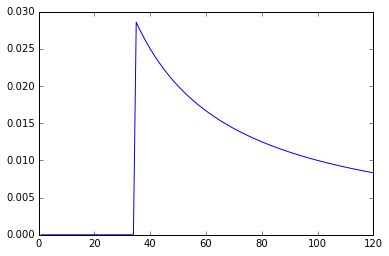

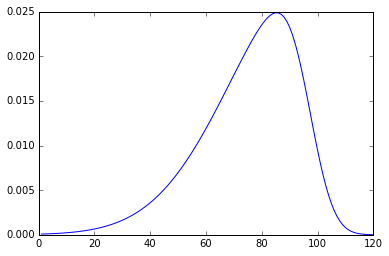

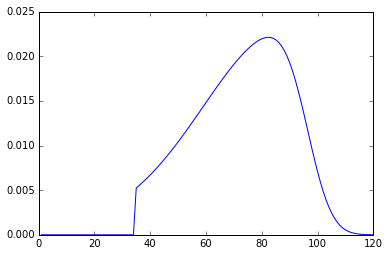

In [2]:

max_age = dim = 120

# likelihood parameters
x = 35  # observed age

# prior parameters
skew = -4
loc = 97
scale = 28

def likelihood(x):
    like = np.asarray([1/p for p in thetas])
    like[0:x-1] = [0]*np.asarray(x-1)
    return like

# our domain is thetas (i.e., age from 1 to 120)
thetas = np.linspace(start=1, stop=max_age, num=max_age)
def skew_gauss(skew, loc, scale):
    return [(st.skewnorm.pdf(p, a=skew, loc=loc, scale=scale)) for p in thetas] 
    
    
def posterior(x, skew, loc, scale):
    post = likelihood(x=x)*skew_gauss(skew=skew, loc=loc, scale=scale)
    post = post/sum(post)
    return post
    

pylab.plot(thetas, likelihood(x=x))
pylab.show()


pylab.plot(thetas, skew_gauss(skew=skew, loc=loc, scale=scale))
pylab.show()

pylab.plot(thetas, posterior(x=x, skew=skew, loc=loc, scale=scale))
pylab.show()


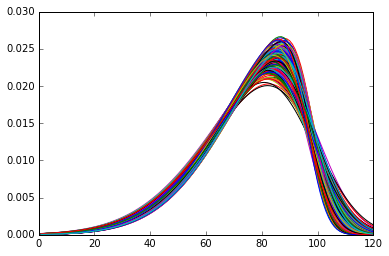

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


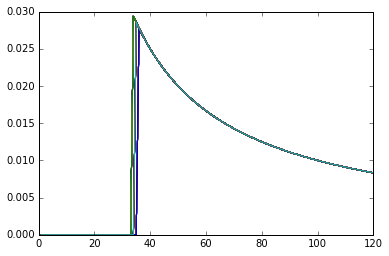

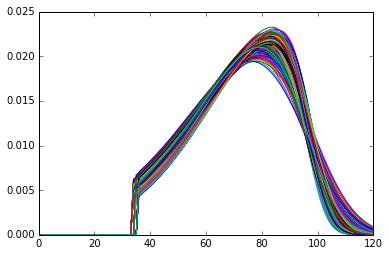

In [3]:
space = nengo.dists.Function(skew_gauss,
                             skew=nengo.dists.Uniform(skew-1, skew+2), 
                          loc=nengo.dists.Uniform(loc-1,loc+2), 
                          scale=nengo.dists.Uniform(scale-1, scale+2))
data = space.sample(200)
pylab.plot(thetas, data.T)
pylab.show()


lik_space = nengo.dists.Function(likelihood,
                             x=nengo.dists.Uniform(x-1,x+2))
data = lik_space.sample(200)
pylab.plot(thetas, data.T)
pylab.show()


post_space = nengo.dists.Function(posterior,
                             x=nengo.dists.Uniform(x-1,x+2),
                            skew=nengo.dists.Uniform(skew-1, skew+2), 
                          loc=nengo.dists.Uniform(loc-1,loc+2), 
                          scale=nengo.dists.Uniform(scale-1, scale+2))

data = post_space.sample(200)
pylab.plot(thetas, data.T)
pylab.show()

Building finished in 0:01:37.                                                   
Simulating finished in 0:00:05.                                                 


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


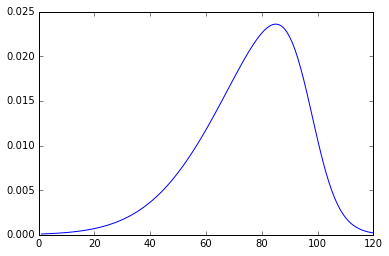

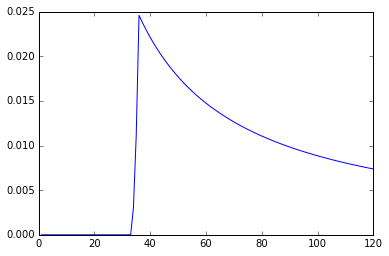

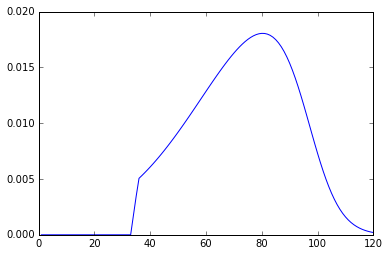

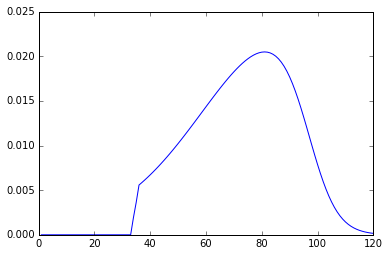

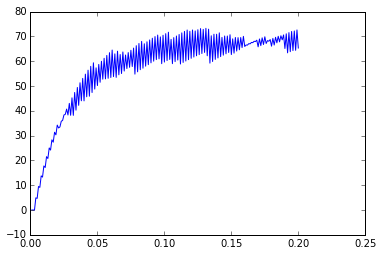

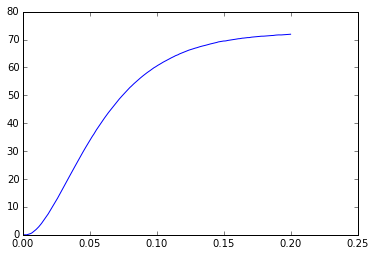

In [7]:
model = nengo.Network(seed=12)
with model:
    stim = nengo.Node(skew_gauss(skew=skew, loc=loc, scale=scale))
    ens = nengo.Ensemble(n_neurons=50, dimensions=dim,
                         encoders=space,
                         eval_points=space,
                        )
    
    stim2 = nengo.Node(likelihood(x=x))
    ens2 = nengo.Ensemble(n_neurons=50, dimensions=dim,
                         encoders=lik_space,
                         eval_points=lik_space,
                        )
    
    
    nengo.Connection(stim, ens)
    probe_func = nengo.Probe(ens, synapse=0.03)
    
    nengo.Connection(stim2, ens2)
    probe_func2 = nengo.Probe(ens2, synapse=0.03)
    
    # elementwise multiplication
    posterior = nengo.Ensemble(n_neurons=50, dimensions=dim,
                             encoders=post_space,
                             eval_points=post_space,
                            )
    product = nengo.networks.Product(n_neurons=50*2, dimensions=dim, input_magnitude=1)
    
    nengo.Connection(ens, product.A)
    nengo.Connection(ens2, product.B)
    nengo.Connection(product.output, posterior)
    probe_func3 = nengo.Probe(posterior, synapse=0.03)
    
    # divisive normalization
    def normalize(a):
        return a
        total = np.sum(a)
        if total == 0:
            return 0
        return [x / total for x in a]
    
    
    norm_post = nengo.Ensemble(n_neurons=50, dimensions=dim, 
                               encoders=post_space,
                             eval_points=post_space)
    
    nengo.Connection(posterior, norm_post, function=normalize)
    probe_func4 = nengo.Probe(norm_post, synapse=0.03)
    
    # prediction
    def median(b):
        med = 0
        for n in np.arange(len(b)):
            cum = sum(b[:n+1])
            if cum == 0.5 or cum > 0.5:
                med = n + 1
                break
        return int(med)
    
    prediction1 = nengo.Ensemble(n_neurons=50, dimensions=1, 
                          encoders=nengo.dists.Uniform(1,121, integer=False), 
                          eval_points=nengo.dists.Uniform(1,121, integer=False))
    
    prediction2 = nengo.Node(output=None, size_in=1)
       
    nengo.Connection(norm_post, prediction1, function=median)
    nengo.Connection(norm_post, prediction2, function=median, synapse=0.03)
    probe_func5 = nengo.Probe(prediction1, synapse=0.03)
    probe_func6 = nengo.Probe(prediction2, synapse=0.03)
    
    
sim = nengo.Simulator(model)
sim.run(0.2)

pylab.plot(thetas, sim.data[probe_func][-1])
pylab.figure()
pylab.show()

pylab.plot(thetas, sim.data[probe_func2][-1])
pylab.figure()
pylab.show()

pylab.plot(thetas, sim.data[probe_func3][-1])
pylab.figure()
pylab.show()

pylab.plot(thetas, sim.data[probe_func4][-1])
pylab.figure()
pylab.show()

pylab.plot(sim.trange(), sim.data[probe_func5])
pylab.figure()
pylab.show()

pylab.plot(sim.trange(), sim.data[probe_func6])
pylab.figure()
pylab.show()

In [6]:
print sum(sim.data[probe_func3][-1])
print sum(sim.data[probe_func4][-1])

print np.max(sim.data[probe_func5]) #[-1]
print np.max(sim.data[probe_func6]) #[-1]

print sim.data[probe_func5][-1]
print sim.data[probe_func6][-1]

0.869719805043
0.972299982858
73.2623772121
71.9001141988
[ 65.33214725]
[ 71.9001142]


In [ ]:
space = []
for i in range(100):
    space.append(skew_gauss(
                          skew=np.random.uniform(skew-1, skew+2), 
                          loc=np.random.uniform(loc-1,loc+2), 
                          scale=np.random.uniform(scale-1, scale+2)))
pylab.plot(thetas, np.array(space).T)
pylab.show()

lik_space = []
for i in range(100):
    lik_space.append(likelihood(x=np.random.uniform(x-1,x+2)))
pylab.plot(thetas, np.array(lik_space).T)
pylab.show()


post_space = []
for i in range(100):
    post_space.append(posterior(x=np.random.uniform(x-1,x+2),
                            skew=np.random.uniform(skew-1, skew+2), 
                          loc=np.random.uniform(loc-1,loc+2), 
                          scale=np.random.uniform(scale-1, scale+2)))
pylab.plot(thetas, np.array(post_space).T)
pylab.show()

In [ ]:
fs = nengo.FunctionSpace(nengo.dists.Function(skew_gauss,
                             skew=nengo.dists.Uniform(-5,-3), 
                          loc=nengo.dists.Uniform(96,98), 
                          scale=nengo.dists.Uniform(27, 29)),
                            n_basis=20)

In [ ]:
model = nengo.Network(seed=15)
with model:
    stim = nengo.Node(fs.project(skew_gauss(skew=-4, loc=97, scale=28)))
    ens = nengo.Ensemble(n_neurons=100, dimensions=fs.n_basis,
                         encoders=fs.project(space),
                         eval_points=fs.project(space))
    nengo.Connection(stim, ens)
    probe_func = nengo.Probe(ens, synapse=0.03)
sim = nengo.Simulator(model)
sim.run(0.2)
pylab.plot(thetas, fs.reconstruct(sim.data[probe_func][-1]))
pylab.figure()
pylab.imshow(fs.reconstruct(sim.data[probe_func]), extent=(-1,1,0.2,0), aspect=10.0)
pylab.ylabel('time')
pylab.show()

In [ ]:
radius = np.mean(np.linalg.norm(space.sample(100), axis=1))
print radius